In [71]:
%matplotlib inline

import numpy as np
import numpy.random as npr

import autograd.numpy as anp
from autograd import grad
from autograd.extend import primitive, defvjp
from autograd.misc.optimizers import adam
from scipy.special import lambertw as lambertw_
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import autograd.scipy.stats.norm as gnorm

npr.seed(100)

In [72]:
lambertw = primitive(lambda x: lambertw_(x,0).real)
defvjp(lambertw, 
           lambda ans, x: lambda g: g * ans/(x*(1+ans)),
           None 
      )

In [91]:
# generate sample data
N = 1000
D = 50
K = 10

scale = 1.
skew = -0.01
theta = npr.randn(N,K) 
beta = npr.randn(D,K) 

loc = np.matmul(theta, beta.T)
u = npr.randn(N,D)
z = u * scale + loc
y = u * np.exp(skew * u) * scale + loc

In [92]:
def unpack_params(params):
    return params[0], params[1], params[2]

def lambertw_logpdf(y, loc, log_scale, skew):
    scale = np.exp(log_scale)
    u = (y - loc)/scale
    if skew != 0:
        u_ = u*skew
        W = lambertw(u_)
        z = W/skew
        jacobian = W/(u_*(1+W))
        return gnorm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale
    else:
        return gnorm.logpdf(u) - log_scale

array([-0.01])

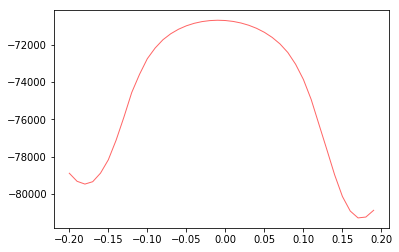

In [104]:
loc = np.matmul(theta, beta.T)
skews = np.arange(-0.2, 0.2, 0.01)
pdf = [np.sum(lambertw_logpdf(y, loc, np.log(1.), skew)) for skew in skews]
plt.plot(skew, pdf, 'r-', lw=1, alpha=0.6)
skews[np.where(pdf == np.max(pdf))]

In [65]:
def make_lambertw_routines(y):
    
    def unpack_params(params):
        theta = anp.reshape(params[:(N*K)], [N, K])
        beta = anp.reshape(params[(N*K):], [D, K])
        return theta, beta
        
    def lambertw_logpdf(theta, beta):
        loc = anp.matmul(theta, beta.T)
        return (gnorm.logpdf(y, loc , 1.))
    
    def objective(params, t):
        theta, beta = unpack_params(params)
        return -anp.sum(lambertw_logpdf(theta, beta))
    return objective, lambertw_logpdf, unpack_params


def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), end ='\r')
    
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten()])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(z)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
theta_f, beta_f = unpack_params(final_params) 

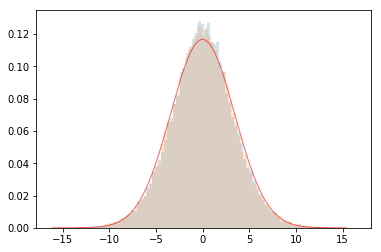

In [66]:
z_new = np.matmul(theta_f, beta_f.T) + npr.randn(N,D)
plt.hist(z_1.flatten(), 100, normed=True, alpha=0.2)
plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
loc = np.mean(z_new)
scale = np.std(z_new)
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(np.sort(z_new.flatten()), norm.pdf(np.sort(z_new.flatten()), loc, scale), 'r-', lw=1, alpha=0.6)
plt.show()

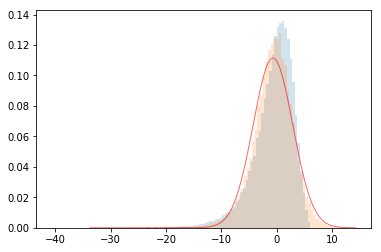

In [41]:
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten()])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
theta_f, beta_f = unpack_params(final_params) 

z_new = np.matmul(theta_f, beta_f.T) + npr.randn(N,D)
plt.hist(y.flatten(), 100, normed=True, alpha=0.2)
plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
loc = np.mean(z_new)
scale = np.std(z_new)
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(np.sort(z_new.flatten()), norm.pdf(np.sort(z_new.flatten()), loc, scale), 'r-', lw=1, alpha=0.6)
plt.show()

In [68]:
def make_lambertw_routines(y):
    
    def unpack_params(params):
        theta = anp.reshape(params[0:(N*K)], [N, K])
        beta = anp.reshape(params[(N*K):], [D, K])
        return theta, beta
        
    def lambertw_logpdf(theta, beta, skew):
        loc = anp.matmul(theta, beta.T)
        scale = 1.
        u = (y - loc)/scale
        u_ = u*skew
        W = lambertw(u_)
        z = W/skew
        jacobian = W/(u_*(1+W))
        return gnorm.logpdf(z) + anp.log(anp.abs(jacobian))
      
    def objective(params, t):
        theta, beta = unpack_params(params)
        return -anp.sum(lambertw_logpdf(theta, beta, -0.2))
    return objective, lambertw_logpdf, unpack_params


def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), end ='\r')
    
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten()])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=2000, callback = callback)
theta_f, beta_f = unpack_params(final_params) 

(array([  5.81724638e-05,   5.81724638e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.81724638e-05,   1.74517391e-04,   0.00000000e+00,
          5.81724638e-05,   5.81724638e-05,   5.81724638e-05,
          5.81724638e-05,   2.90862319e-04,   3.49034783e-04,
          2.90862319e-04,   4.07207247e-04,   2.90862319e-04,
          5.23552174e-04,   9.30759421e-04,   8.14414493e-04,
          1.22162174e-03,   8.72586957e-04,   2.21055363e-03,
          2.26872609e-03,   2.44324348e-03,   3.08314058e-03,
          3.08314058e-03,   6.34079856e-03,   5.93359131e-03,
          7.85328262e-03,   1.04128710e-02,   1.06455609e-02,
          1.35541841e-02,   1.90223957e-02,   1.89060507e-02,
          2.16983290e-02,   2.76900928e-02,   3.29256145e-02,
          3.61832725e-02,   4.26404160e-02,   4.85740073e-02,
          5.68926696e-02,   6.48622972e-02,   7.41117189e-02,
          7.87655160e-02,   8.66187986e-02,   9.26687349e-02,
        

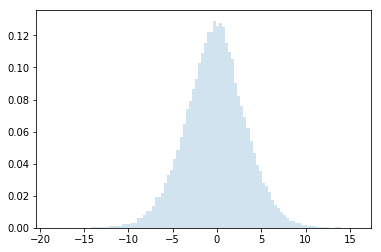

In [70]:
# z_new = np.matmul(theta_f, beta_f.T) + npr.randn(N,D)
# plt.hist(y.flatten(), 100, normed=True, alpha=0.2) 
# plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
# loc = np.mean(z_new)
# scale = np.std(z_new)
# x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
# plt.plot(np.sort(z_new.flatten()), norm.pdf(np.sort(z_new.flatten()), loc, scale), 'r-', lw=1, alpha=0.6)
# plt.show()